In [1]:
import torch
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from string import punctuation
from collections import defaultdict
from time import time

In [2]:
def remove_punct(verse):
  verse = verse.translate(str.maketrans('','', punctuation))
  verse = verse.lower()
  return verse

In [3]:
train_df = pd.read_csv('train.csv')
train_df.lyric = train_df.lyric.apply(lambda x: remove_punct(x))

test_df = pd.read_csv('test.csv')
test_df.lyric = test_df.lyric.apply(lambda x: remove_punct(x))

In [4]:
train_df

,Unnamed: 0,artist,song,lyric
0,0,Future,Osama (O’s),i ride with dope like its legal
1,1,Future,Coupe,this my environment
2,2,Future,Substitute Everything,im tryna substitute everything
3,3,Future,Straight Up,throw some red bottoms jimmy choos be all you ...
4,4,Future,Never Satisfied (Original Version),aint no pressure on the money lord knows
...,...,...,...,...
48055,48055,Kendrick Lamar,King Kunta,oh yes we can oh yes we can
48056,48056,Kendrick Lamar,Waitin,catch him at the lights to turn off his lights...
48057,48057,Kendrick Lamar,Compton Life,lets bring it back
48058,48058,Kendrick Lamar,Poe Mans Dreams (His Vice),be on my last dollar and split the bill with you


In [5]:
test_df

,Unnamed: 0,artist,song,lyric
0,0,Future,My,already don ordered it
1,1,Future,Good Morning,every time i see her i swear we get deeper and...
2,2,Future,Turn on Me,with this dope in my system i know you gon tur...
3,3,Future,You Deserve It,you deserve it
4,4,Future,Secure the Bag,first time i seen it online went and copped it
...,...,...,...,...
12008,12008,Kendrick Lamar,Blow My High (Members Only),look at my life and look at yours
12009,12009,Kendrick Lamar,Freestyle vs Fan (On Rigamortis Beat),thats that scream that every other clapper scared
12010,12010,Kendrick Lamar,These Walls,i remember you was conflicted misusing your in...
12011,12011,Kendrick Lamar,Poetic Justice,you can get it you can get it


In [6]:
class LyricDataset(Dataset):
  def __init__(self, df, cond=None, seq_len=5):
    self.data = df.lyric.to_list()
    self.category =  list(df.artist.unique())
    self.encode_cat = {key:val for val, key in enumerate(self.category)}
    self.stoi = {**{'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}, 
                 **{j:i for i, j in enumerate(set([word for word in ' '.join(self.data).split()]), start=4)}}
    self.itos = {**{0:'<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'}, 
                 **{i:j for i, j in enumerate(set([word for word in ' '.join(self.data).split()]), start=4)}}
    self.full_text = ' '.join(self.data)
    self.full_idx = [self.stoi[word] for word in self.full_text.split()]
    self.seq_len = seq_len 
    self.cond = cond
    self.full_artists = self.artist_list(df)

  # Bars are split by seq_len; attach artist to each possible sliding window.
  def artist_list(self, df):
    artist_list = []
    for artist in self.category:
      subdf = df[df.artist==artist]
      text = ' '.join(subdf.lyric.to_list()).split()
      artist_list += [artist]*len(text)
    return artist_list

  def __len__(self):
    return len(self.stoi)

  def __getitem__(self, idx):
    cat = self.encode_cat[self.full_artists[idx]]
    input = torch.tensor(self.full_idx[idx:idx+self.seq_len])
    target = torch.tensor(self.full_idx[idx+1:idx+self.seq_len+1])
    return cat, input, target

In [7]:
class GRU_Model(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(GRU_Model, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.gru_layer = nn.GRU(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )
    self.cond_layer = nn.Linear(
    1,
    128,
    bias=False
    )

  def forward(self, cat, x, hidden, cond=None):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    if cond=='add':
      out = torch.add(out, cout)
    elif cond=='mul':
      out = torch.mul(out, cout)
    out, hid = self.gru_layer(out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [8]:
class LSTM_Model(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(LSTM_Model, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.lstm_layer = nn.LSTM(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )

    self.cond_layer = nn.Linear(
        1,
        128,
        bias=False
    )


  def forward(self, cat, x, hidden, cond=None):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    if cond=='add':
      out = torch.add(out, cout)
    elif cond=='mul':
      out = torch.mul(out, cout)
    out, hid = self.lstm_layer(out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [9]:
def RNN_train(model, dataset, batch_dim=32, lr=1e-3, epochs=15, cond=None):
  model.train()
  loader = DataLoader(dataset, batch_size=batch_dim)
  crit = nn.CrossEntropyLoss()
  opt = optim.Adam(model.parameters(), lr=lr)

  start = time()
  
  losses = []
  for epoch in range(epochs):
    h, c = model.init_hidden()

    for batch, (cat, input, target) in enumerate(loader):
      val = cat.data[0]
      cat_tens = torch.full_like(input, val)
      #print(batch, input.shape, cat_tens.shape)
      cat_tens = cat_tens.type(torch.FloatTensor)
      cat_tens = torch.unsqueeze(cat_tens, 2).to('cuda')
      input = input.to('cuda')
      target = target.to('cuda')

      opt.zero_grad()
      pred, (h,c) = model(cat_tens, input, (h, c), cond=cond)
      loss = crit(pred.transpose(1,2), target)

      loss.backward()
      opt.step()
    
    elapsed = time() - start
    losses.append(loss.item())
    print(f'epoch: {epoch+1}, loss: {loss.item()}, elapsed: {elapsed:.2f} s')
  return losses

In [11]:
dataset = LyricDataset(train_df)

In [55]:
LSTM_model_add = LSTM_Model(dataset)
LSTM_model_add.to('cuda')

LSTM_Model(
  (emb_layer): Embedding(16783, 128)
  (lstm_layer): LSTM(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
)

In [56]:
LSTM_add_loss = RNN_train(LSTM_model_add, dataset, cond='add', epochs=15)

epoch: 1, loss: 6.397597789764404, elapsed: 3.53 s
epoch: 2, loss: 5.960576057434082, elapsed: 7.06 s
epoch: 3, loss: 5.596567153930664, elapsed: 10.59 s
epoch: 4, loss: 5.302640914916992, elapsed: 14.11 s
epoch: 5, loss: 4.886469841003418, elapsed: 17.64 s
epoch: 6, loss: 4.5449323654174805, elapsed: 21.17 s
epoch: 7, loss: 4.3169050216674805, elapsed: 24.71 s
epoch: 8, loss: 4.034762382507324, elapsed: 28.24 s
epoch: 9, loss: 3.7045156955718994, elapsed: 31.77 s
epoch: 10, loss: 3.4333765506744385, elapsed: 35.30 s
epoch: 11, loss: 3.168856382369995, elapsed: 38.83 s
epoch: 12, loss: 2.798696756362915, elapsed: 42.36 s
epoch: 13, loss: 2.477689266204834, elapsed: 45.89 s
epoch: 14, loss: 2.3091673851013184, elapsed: 49.43 s
epoch: 15, loss: 2.0638837814331055, elapsed: 53.03 s


In [38]:
LSTM_model_mul = LSTM_Model(dataset)
LSTM_model_mul.to('cuda')

LSTM_Model(
  (emb_layer): Embedding(16783, 128)
  (lstm_layer): LSTM(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
)

In [39]:
LSTM_mul_loss = RNN_train(LSTM_model_mul, dataset, cond='mul', epochs=15)

epoch: 1, loss: 6.569474220275879, elapsed: 3.54 s
epoch: 2, loss: 6.254977703094482, elapsed: 7.07 s
epoch: 3, loss: 6.113901138305664, elapsed: 10.60 s
epoch: 4, loss: 6.020262241363525, elapsed: 14.13 s
epoch: 5, loss: 5.9142961502075195, elapsed: 17.66 s
epoch: 6, loss: 5.787648677825928, elapsed: 21.19 s
epoch: 7, loss: 5.8221001625061035, elapsed: 24.73 s
epoch: 8, loss: 5.592106342315674, elapsed: 28.26 s
epoch: 9, loss: 5.547795295715332, elapsed: 31.79 s
epoch: 10, loss: 5.703165054321289, elapsed: 35.33 s
epoch: 11, loss: 5.482362270355225, elapsed: 38.86 s
epoch: 12, loss: 5.489552021026611, elapsed: 42.39 s
epoch: 13, loss: 5.626899242401123, elapsed: 45.92 s
epoch: 14, loss: 5.496450424194336, elapsed: 49.58 s
epoch: 15, loss: 5.398554801940918, elapsed: 53.11 s


In [21]:
GRU_model_add = GRU_Model(dataset)
GRU_model_add.to('cuda')

GRU_Model(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
)

In [22]:
GRU_add_loss = RNN_train(GRU_model_add, dataset, cond='add', epochs=15)

epoch: 1, loss: 6.4024577140808105, elapsed: 3.45 s
epoch: 2, loss: 5.504766464233398, elapsed: 6.88 s
epoch: 3, loss: 4.88184928894043, elapsed: 10.31 s
epoch: 4, loss: 4.3351263999938965, elapsed: 13.74 s
epoch: 5, loss: 3.8374266624450684, elapsed: 17.17 s
epoch: 6, loss: 3.256939172744751, elapsed: 20.73 s
epoch: 7, loss: 2.8036131858825684, elapsed: 24.24 s
epoch: 8, loss: 2.195232629776001, elapsed: 27.67 s
epoch: 9, loss: 1.9160429239273071, elapsed: 31.10 s
epoch: 10, loss: 1.4964778423309326, elapsed: 34.52 s
epoch: 11, loss: 1.2374624013900757, elapsed: 37.95 s
epoch: 12, loss: 1.1330047845840454, elapsed: 41.44 s
epoch: 13, loss: 0.8482736945152283, elapsed: 44.87 s
epoch: 14, loss: 0.8103534579277039, elapsed: 48.33 s
epoch: 15, loss: 0.6355587840080261, elapsed: 52.09 s


In [46]:
GRU_model_mul = GRU_Model(dataset)
GRU_model_mul.to('cuda')

GRU_Model(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
)

In [47]:
GRU_mul_loss = RNN_train(GRU_model_mul, dataset, cond='mul', epochs=15)

epoch: 1, loss: 6.511735439300537, elapsed: 3.45 s
epoch: 2, loss: 6.05702018737793, elapsed: 6.89 s
epoch: 3, loss: 5.867367267608643, elapsed: 10.33 s
epoch: 4, loss: 5.7372331619262695, elapsed: 13.77 s
epoch: 5, loss: 5.665899276733398, elapsed: 17.21 s
epoch: 6, loss: 5.595876693725586, elapsed: 20.65 s
epoch: 7, loss: 5.609720230102539, elapsed: 24.09 s
epoch: 8, loss: 5.524279594421387, elapsed: 27.54 s
epoch: 9, loss: 5.509462356567383, elapsed: 31.05 s
epoch: 10, loss: 5.548664093017578, elapsed: 34.49 s
epoch: 11, loss: 5.5436110496521, elapsed: 37.93 s
epoch: 12, loss: 5.519361972808838, elapsed: 41.39 s
epoch: 13, loss: 5.634439468383789, elapsed: 44.83 s
epoch: 14, loss: 5.489741802215576, elapsed: 48.27 s
epoch: 15, loss: 5.442396640777588, elapsed: 51.71 s


In [12]:
def create_lyric(model, dataset, input, artist, bar_len=15):
  model.eval()
  words = input.split()
  artist = dataset.encode_cat[artist]
  h, c = model.init_hidden()
  tokens = np.array([dataset.stoi[word] for word in input.split()])

  def predict(model, dataset, tensor, artist, h, c):
    cat_tens = torch.full_like(tensor, artist)
    cat_tens = cat_tens.type(torch.FloatTensor)
    cat_tens = torch.unsqueeze(cat_tens, 2).to('cuda')
    out, (h, c) = model(cat_tens, tensor, (h,c))
    token_prob = F.softmax(out[0][2], dim=0).detach().cpu().numpy()
    rand_idx = np.random.choice(len(dataset), p=token_prob)
    return dataset.itos[rand_idx], (h, c)

  for i in range(bar_len):
    sub = words[i:i+dataset.seq_len]
    pred_word, (h, c) = predict(model, dataset, torch.tensor([[dataset.stoi[word] for word in sub]]).to('cuda'), artist, h, c)
    words.append(pred_word)

  return ' '.join(words)

In [13]:
class FiLM_Generator(nn.Module):
  def __init__(self):
    super(FiLM_Generator, self).__init__()
    self.fc1 = nn.Linear(128, 64)
    self.sig1 = nn.Sigmoid()
    self.fc2 = nn.Linear(64, 128*2)

  def forward(self, x):
    out = self.fc1(x)
    out = self.sig1(out)
    out = self.fc2(out)
    gamma = out[:,:,:128]
    beta = out[:,:,128:]
    return gamma, beta

class FiLM_Layer(nn.Module):
  def __init__(self):
    super(FiLM_Layer, self).__init__()
    self.gen = FiLM_Generator()

  def forward(self, cout, x):
    gamma, beta = self.gen(cout)
    out = gamma * x + beta
    return out

In [14]:
class FiLMed_GRU_Model(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(FiLMed_GRU_Model, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.gru_layer = nn.GRU(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )
    self.cond_layer = nn.Linear(
    1,
    128,
    bias=False
    )
    self.FiLM = FiLM_Layer()

  def forward(self, cat, x, hidden):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    out, hid = self.gru_layer(out)
    out = self.FiLM(cout, out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [15]:
class FiLMed_LSTM_Model(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(FiLMed_LSTM_Model, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.lstm_layer = nn.LSTM(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )
    self.cond_layer = nn.Linear(
    1,
    128,
    bias=False
    )
    self.FiLM = FiLM_Layer()

  def forward(self, cat, x, hidden):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    out, hid = self.lstm_layer(out)
    out = self.FiLM(cout, out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [16]:
def FiLMed_train(model, dataset, batch_dim=32, lr=1e-3, epochs=15):
  model.train()
  loader = DataLoader(dataset, batch_size=batch_dim)
  crit = nn.CrossEntropyLoss()
  opt = optim.Adam(model.parameters(), lr=lr)

  start = time()
  losses = []
  for epoch in range(epochs):
    h, c = model.init_hidden()

    for batch, (cat, input, target) in enumerate(loader):
      val = cat.data[0]
      cat_tens = torch.full_like(input, val)
      cat_tens = cat_tens.type(torch.FloatTensor)
      cat_tens = torch.unsqueeze(cat_tens, 2).to('cuda')
      input = input.to('cuda')
      target = target.to('cuda')

      opt.zero_grad()
      pred, (h,c) = model(cat_tens, input, (h, c))
      loss = crit(pred.transpose(1,2), target)

      loss.backward()
      opt.step()
    
    losses.append(loss.item())
    elapsed = time() - start
    print(f'epoch: {epoch+1}, loss: {loss.item()}, elapsed: {elapsed:.2f} s')
  return losses

In [17]:
FiLMed_GRU = FiLMed_GRU_Model(dataset)
FiLMed_GRU.to('cuda')

FiLMed_GRU_Model(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
  (FiLM): FiLM_Layer(
    (gen): FiLM_Generator(
      (fc1): Linear(in_features=128, out_features=64, bias=True)
      (sig1): Sigmoid()
      (fc2): Linear(in_features=64, out_features=256, bias=True)
    )
  )
)

In [18]:
GRU_FiLMed_losses = FiLMed_train(FiLMed_GRU, dataset, epochs=15)

epoch: 1, loss: 5.949640274047852, elapsed: 3.68 s
epoch: 2, loss: 4.7576727867126465, elapsed: 7.29 s
epoch: 3, loss: 3.0678327083587646, elapsed: 10.91 s
epoch: 4, loss: 1.5630372762680054, elapsed: 14.67 s
epoch: 5, loss: 1.1635074615478516, elapsed: 18.78 s
epoch: 6, loss: 0.8442501425743103, elapsed: 22.73 s
epoch: 7, loss: 0.9807001948356628, elapsed: 26.52 s
epoch: 8, loss: 0.7367600798606873, elapsed: 30.13 s
epoch: 9, loss: 0.6737814545631409, elapsed: 33.74 s
epoch: 10, loss: 0.5497861504554749, elapsed: 37.35 s
epoch: 11, loss: 0.3772864043712616, elapsed: 40.96 s
epoch: 12, loss: 0.24991370737552643, elapsed: 44.57 s
epoch: 13, loss: 0.4476940929889679, elapsed: 48.18 s
epoch: 14, loss: 0.5974217653274536, elapsed: 51.79 s
epoch: 15, loss: 0.3015216290950775, elapsed: 55.41 s


In [30]:
FiLMed_LSTM = FiLMed_LSTM_Model(dataset)
FiLMed_LSTM.to('cuda')

FiLMed_LSTM_Model(
  (emb_layer): Embedding(16783, 128)
  (lstm_layer): LSTM(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=16783, bias=True)
  (cond_layer): Linear(in_features=1, out_features=128, bias=False)
  (FiLM): FiLM_Layer(
    (gen): FiLM_Generator(
      (fc1): Linear(in_features=128, out_features=64, bias=True)
      (sig1): Sigmoid()
      (fc2): Linear(in_features=64, out_features=256, bias=True)
    )
  )
)

In [31]:
LSTM_FiLMed_losses = FiLMed_train(FiLMed_LSTM, dataset, epochs=15)

epoch: 1, loss: 6.144692897796631, elapsed: 3.95 s
epoch: 2, loss: 5.273354530334473, elapsed: 7.70 s
epoch: 3, loss: 4.314802169799805, elapsed: 11.45 s
epoch: 4, loss: 3.2003235816955566, elapsed: 15.19 s
epoch: 5, loss: 2.409721612930298, elapsed: 18.94 s
epoch: 6, loss: 1.6091773509979248, elapsed: 22.69 s
epoch: 7, loss: 1.1383036375045776, elapsed: 26.44 s
epoch: 8, loss: 0.9606184959411621, elapsed: 30.19 s
epoch: 9, loss: 0.719239354133606, elapsed: 33.94 s
epoch: 10, loss: 0.5935797095298767, elapsed: 37.69 s
epoch: 11, loss: 0.44358500838279724, elapsed: 41.44 s
epoch: 12, loss: 0.7130871415138245, elapsed: 45.19 s
epoch: 13, loss: 0.4286450743675232, elapsed: 48.94 s
epoch: 14, loss: 0.3357324004173279, elapsed: 52.69 s
epoch: 15, loss: 0.37198248505592346, elapsed: 56.44 s


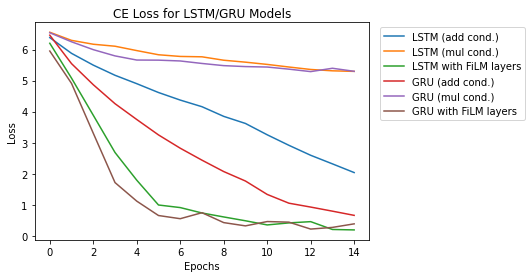

In [41]:
plt.plot(list(range(15)), LSTM_add_loss, label='LSTM (add cond.)')
plt.plot(list(range(15)), LSTM_mul_loss, label='LSTM (mul cond.)')
plt.plot(list(range(15)), LSTM_FiLMed_losses, label='LSTM with FiLM layers')
plt.plot(list(range(15)), GRU_add_loss, label='GRU (add cond.)')
plt.plot(list(range(15)), GRU_mul_loss, label='GRU (mul cond.)')
plt.plot(list(range(15)), GRU_FiLMed_losses, label='GRU with FiLM layers')
plt.title('CE Loss for LSTM/GRU Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.48,1), loc='upper right')
plt.show()

In [95]:
input = 'i love the'
artist = 'Kendrick Lamar'
create_lyric(model, dataset, input, artist)

'i love the club just in a nigga freebandz out that shit if you lookin immigrants all this'

In [92]:
input = 'i love the'
artist = 'Freddie Gibbs'
create_lyric(model, dataset, input, artist)

'i love the game got a nigga lets ice on a new jewelry when i just been payin'

In [88]:
input = 'i love the'
artist = 'Future'
create_lyric(model, dataset, input, artist)

'i love the slammer and we poured an ounce in the ceiling it aint never been payin off'

In [64]:
class Generator(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(Generator, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.gru_layer = nn.GRU(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )
    self.cond_layer = nn.Linear(
    1,
    128,
    bias=False
    )

  def forward(self, cat, x, hidden, cond=None):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    if cond=='add':
      out = torch.add(out, cout)
    elif cond=='mul':
      out = torch.mul(out, cout)
    out, hid = self.gru_layer(out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [65]:
class FiLMed_Generator(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(FiLMed_Generator, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.gru_layer = nn.GRU(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        self.vocab_dim
    )
    self.cond_layer = nn.Linear(
    1,
    128,
    bias=False
    )
    self.FiLM = FiLM_Layer()

  def forward(self, cat, x, hidden, cond=None):
    out = self.emb_layer(x)
    cout = self.cond_layer(cat)
    out, hid = self.gru_layer(out)
    out = self.FiLM(cout, out)
    out = self.lin_layer(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [66]:
class Discriminator(nn.Module):
  def __init__(self, dataset, batch_dim=32):
    super(Discriminator, self).__init__()
    self.vocab_dim = len(dataset.stoi)
    self.seq_len = dataset.seq_len
    self.batch_dim = batch_dim

    self.emb_layer = nn.Embedding(
        num_embeddings=self.vocab_dim,
        embedding_dim=128
    )
    self.gru_layer = nn.GRU(
        input_size=128,
        hidden_size=128,
        num_layers=2,
        dropout=0.2
    )
    self.lin_layer = nn.Linear(
        128,
        1
    )
    self.sig = nn.Sigmoid()

  def forward(self, x, hidden):
    out = self.emb_layer(x)
    out, hid = self.gru_layer(out)
    out = self.lin_layer(out)
    out = self.sig(out)
    return out, hid

  def init_hidden(self):
    return torch.zeros(2, self.batch_dim, 128), torch.zeros(2, self.batch_dim, 128)

In [125]:
def GAN_train(gen, dis, dataset, batch_dim=32, lr=0.000002, epochs=15, cond=None, film=False):
  gen.train()
  dis.train()
  gen_opt = optim.Adam(gen.parameters(), lr=lr)
  dis_opt = optim.Adam(dis.parameters(), lr=lr)

  loader = DataLoader(dataset, batch_size=batch_dim)
  crit = nn.BCELoss()

  high = len(dataset)-1

  # Given random noise, generate (batch_dim, 5) size output tensor.
  def fake_gen(cat_tens, noise, h, c):
    tokens = noise
    for j in range(5):
      sub = tokens[:, j:j+5].long()
      out_prob, (h,c) = gen(cat_tens, sub, (h,c), cond=cond)
      token_prob = F.softmax(out_prob[:,-1,:], dim=0).to('cuda')
      new = torch.multinomial(token_prob, 1).to('cuda')
      tokens = torch.cat((tokens, new),1).to('cuda')
    fake = tokens[:, -5:].to('cuda')
    return fake

  start = time()
  
  gen_losses = []
  dis_losses = []
  for epoch in range(epochs):
    h, c = gen.init_hidden()

    for batch, (cat, input, target) in enumerate(loader):
      val = cat.data[0]
      cat_tens = torch.full((batch_dim,5,1), val).type(torch.FloatTensor).to('cuda')
      input = input.to('cuda')
      target = target.to('cuda')

      noise = torch.randint(low=0, high=high, size=(batch_dim,5)).to('cuda')
      fake = fake_gen(cat_tens, noise, h, c)

      # Train disc 
      dis_opt.zero_grad()
      pred_r, (h,c) = dis(input, (h,c))
      loss_r = crit(pred_r, torch.ones_like(pred_r).to('cuda'))
      loss_r.backward()

      pred_f, (h,c) = dis(fake, (h,c))
      loss_f = crit(pred_f, torch.zeros_like(pred_f).to('cuda'))
      loss_f.backward()

      dis_opt.step()
      d_loss = loss_r + loss_f

      # Train gen
      noise = torch.randint(low=0, high=high, size=(batch_dim,5)).to('cuda')
      fake = fake_gen(cat_tens, noise, h, c)

      gen_opt.zero_grad()
      pred, (h,c) = dis(fake, (h,c))
      g_loss = crit(pred, torch.ones_like(pred).to('cuda'))
      g_loss.backward()
      gen_opt.step()

    elapsed = time() - start
    gen_losses.append(g_loss.item())
    dis_losses.append(d_loss.item())
    print(f'epoch: {epoch+1}, gen_loss: {g_loss.item()},  dis_loss: {d_loss.item()}, elapsed: {elapsed:.2f} s')
  return gen_losses, dis_losses

In [130]:
batch_dim = 16
gen_add = Generator(dataset, batch_dim=batch_dim)
dis_add = Discriminator(dataset, batch_dim=batch_dim)
gen_add.to('cuda')
dis_add.to('cuda')

Discriminator(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [131]:
GEN_add_loss, DIS_add_loss = GAN_train(gen_add, dis_add, dataset, cond='add', epochs=15, batch_dim=batch_dim)

epoch: 1, gen_loss: 0.7425898909568787,  dis_loss: 1.3862663507461548, elapsed: 19.29 s
epoch: 2, gen_loss: 0.7195472121238708,  dis_loss: 1.3707525730133057, elapsed: 38.46 s
epoch: 3, gen_loss: 0.7221159934997559,  dis_loss: 1.3733797073364258, elapsed: 57.63 s
epoch: 4, gen_loss: 0.7247930765151978,  dis_loss: 1.3198505640029907, elapsed: 76.86 s
epoch: 5, gen_loss: 0.7472826242446899,  dis_loss: 1.2890608310699463, elapsed: 96.03 s
epoch: 6, gen_loss: 0.7326573729515076,  dis_loss: 1.2439481019973755, elapsed: 115.19 s
epoch: 7, gen_loss: 0.727276086807251,  dis_loss: 1.162832498550415, elapsed: 134.36 s
epoch: 8, gen_loss: 0.9186684489250183,  dis_loss: 1.1084038019180298, elapsed: 153.53 s
epoch: 9, gen_loss: 0.8969550132751465,  dis_loss: 1.0201292037963867, elapsed: 172.80 s
epoch: 10, gen_loss: 1.1000782251358032,  dis_loss: 0.9162951111793518, elapsed: 191.99 s
epoch: 11, gen_loss: 1.304594874382019,  dis_loss: 0.7558757066726685, elapsed: 211.21 s
epoch: 12, gen_loss: 1.5829

In [132]:
gen_mul = Generator(dataset, batch_dim=batch_dim)
dis_mul = Discriminator(dataset, batch_dim=batch_dim)
gen_mul.to('cuda')
dis_mul.to('cuda')

Discriminator(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [133]:
GEN_mul_loss, DIS_mul_loss = GAN_train(gen_mul, dis_mul, dataset, cond='mul', epochs=15, batch_dim=batch_dim)

epoch: 1, gen_loss: 0.7002310156822205,  dis_loss: 1.3395066261291504, elapsed: 19.16 s
epoch: 2, gen_loss: 0.6991201043128967,  dis_loss: 1.3136051893234253, elapsed: 38.29 s
epoch: 3, gen_loss: 0.7065899968147278,  dis_loss: 1.2857344150543213, elapsed: 57.41 s
epoch: 4, gen_loss: 0.6877476572990417,  dis_loss: 1.2334104776382446, elapsed: 76.54 s
epoch: 5, gen_loss: 0.7333046793937683,  dis_loss: 1.1277557611465454, elapsed: 95.70 s
epoch: 6, gen_loss: 0.8505059480667114,  dis_loss: 1.1119898557662964, elapsed: 114.84 s
epoch: 7, gen_loss: 0.8886184692382812,  dis_loss: 1.0424985885620117, elapsed: 133.98 s
epoch: 8, gen_loss: 1.0545638799667358,  dis_loss: 0.8392280340194702, elapsed: 153.08 s
epoch: 9, gen_loss: 1.1961573362350464,  dis_loss: 0.7986138463020325, elapsed: 172.22 s
epoch: 10, gen_loss: 1.3005857467651367,  dis_loss: 0.644656240940094, elapsed: 191.36 s
epoch: 11, gen_loss: 1.5220683813095093,  dis_loss: 0.7038370370864868, elapsed: 210.54 s
epoch: 12, gen_loss: 1.69

In [134]:
gen_FiLMed = FiLMed_Generator(dataset, batch_dim=batch_dim)
dis_FiLMed = Discriminator(dataset, batch_dim=batch_dim)
gen_FiLMed.to('cuda')
dis_FiLMed.to('cuda')

Discriminator(
  (emb_layer): Embedding(16783, 128)
  (gru_layer): GRU(128, 128, num_layers=2, dropout=0.2)
  (lin_layer): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [135]:
GENFILM_loss, DISFILM_loss = GAN_train(gen_FiLMed, dis_FiLMed, dataset, cond=None, epochs=15, batch_dim=batch_dim)

epoch: 1, gen_loss: 0.664436936378479,  dis_loss: 1.3685319423675537, elapsed: 19.90 s
epoch: 2, gen_loss: 0.6629568338394165,  dis_loss: 1.3621240854263306, elapsed: 39.68 s
epoch: 3, gen_loss: 0.6986653208732605,  dis_loss: 1.3322172164916992, elapsed: 59.60 s
epoch: 4, gen_loss: 0.6966085433959961,  dis_loss: 1.2838754653930664, elapsed: 79.50 s
epoch: 5, gen_loss: 0.7701794505119324,  dis_loss: 1.255550503730774, elapsed: 99.33 s
epoch: 6, gen_loss: 0.7825640439987183,  dis_loss: 1.14274263381958, elapsed: 119.18 s
epoch: 7, gen_loss: 0.8010849952697754,  dis_loss: 1.1321187019348145, elapsed: 139.01 s
epoch: 8, gen_loss: 1.0220820903778076,  dis_loss: 0.9310767650604248, elapsed: 158.88 s
epoch: 9, gen_loss: 1.410179853439331,  dis_loss: 0.787137508392334, elapsed: 178.75 s
epoch: 10, gen_loss: 1.4535194635391235,  dis_loss: 0.6482558846473694, elapsed: 198.55 s
epoch: 11, gen_loss: 1.8758491277694702,  dis_loss: 0.5926453471183777, elapsed: 218.35 s
epoch: 12, gen_loss: 1.9399391

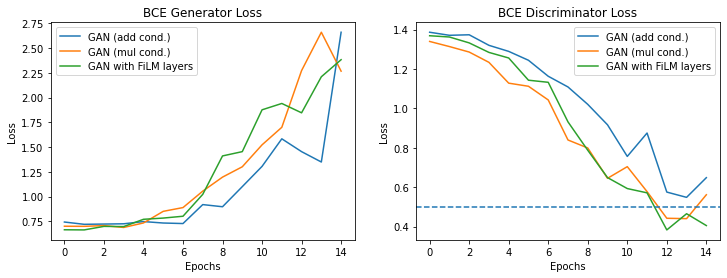

In [137]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(range(15)), GEN_add_loss, label='GAN (add cond.)')
plt.plot(list(range(15)), GEN_mul_loss, label='GAN (mul cond.)')
plt.plot(list(range(15)), GENFILM_loss, label='GAN with FiLM layers')
plt.title('BCE Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(15)), DIS_add_loss, label='GAN (add cond.)')
plt.plot(list(range(15)), DIS_mul_loss, label='GAN (mul cond.)')
plt.plot(list(range(15)), DISFILM_loss, label='GAN with FiLM layers')
plt.axhline(0.5, linestyle='--')
plt.title('BCE Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [138]:
test_set = LyricDataset(test_df)
test_list = [tup[1] for tup in list(test_set)]
test_tens = torch.reshape(torch.cat(test_list), (-1,5)).double()[:10000,:].to('cuda')

In [148]:
def gen_batch(dataset, model, cat_tens, h, c, dim, cond=None):
  noise = torch.randint(low=0, high=len(dataset), size=(dim,5)).to('cuda')
  for j in range(5):
    sub = noise[:, j:j+5].long()
    out_prob, (h,c) = model(cat_tens, sub, (h,c), cond=cond)
    token_prob = F.softmax(out_prob[:,-1,:], dim=0).to('cuda')
    new = torch.multinomial(token_prob, 1).to('cuda')
    noise = torch.cat((noise, new),1).to('cuda')
  generated = noise[:, -5:].to('cuda')
  return generated

In [149]:
model = gen_FiLMed

In [150]:
val = random.choice([0,1,2])
cat_tens = torch.full((10000,5,1), val).type(torch.FloatTensor).to('cuda')
h, c = model.init_hidden()
generated = gen_batch(dataset, model, cat_tens, h, c, dim=10000, cond=None)
gen_tens = generated.double()

In [101]:
def fid(tens1, tens2):
  m1 = torch.mean(tens1)
  m2 = torch.mean(tens2)
  dist = torch.pow((m1-m2),2)
  cov1 = torch.cov(tens1)
  cov2 = torch.cov(tens2)
  tr = torch.trace(cov1 + cov2 - 2*torch.sqrt(cov1*cov2))
  return dist.item() + tr.item()

In [151]:
fid(test_tens, gen_tens)

76651233147.13625

In [147]:
del model
torch.cuda.empty_cache()